In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')


import os
os.listdir('/content/drive/MyDrive/DL2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['binaryalphadigs.mat',
 'Baoueb_Lahbib_Final.ipynb',
 'mnist_all.mat',
 'TP_DNN.ipynb']

##Setup

In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import LabelBinarizer

In [3]:
#Load Alpha BinaryDigits
def lire_alpha_digit(target_select,data_path):


  data = loadmat(data_path)
  classlabels = [c[0] for c in data['classlabels'][0]]
  indices = [classlabels.index(c) for c in target_select if c in classlabels]
  data_select = data['dat'][indices]
  data_flattened = np.array([[data_select[i, j].reshape(-1) for j in range(data_select.shape[1])] for i in range(data_select.shape[0])])
  data_merge_classes = data_flattened.reshape(-1,data_flattened.shape[2])
  return data_merge_classes

# Load MNIST dataset
def load_MNIST_data(target_select,data_path):
  data = loadmat(data_path)
  train_dataset = dict()
  test_dataset = dict()
  for c in target_select:
    train_key = 'train' + c
    test_key = 'test' + c
    train_dataset[c]= data[train_key]
    test_dataset[c]= data[test_key]

  return train_dataset, test_dataset

##Classes

In [9]:
class RBM:
    def __init__(self, n_visible, n_hidden):
        self.n_visible = n_visible  # Nombre d'unités visibles
        self.n_hidden = n_hidden  # Nombre d'unités cachées
        self.W = np.random.normal(0, 0.01, (n_visible, n_hidden))  # Poids initialisés
        self.a = np.zeros(n_visible)  # Biais pour les unités visibles
        self.b = np.zeros(n_hidden)  # Biais pour les unités cachées

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def entree_sortie_RBM(self, donnees_entree):
        return self.sigmoid(np.dot(donnees_entree, self.W) + self.b)

    def sortie_entree_RBM(self, donnees_sortie):
        return self.sigmoid(np.dot(donnees_sortie, self.W.T) + self.a)

    def train_RBM(self, donnees_entree, epochs, learning_rate, batch_size, stratify=False,verbose=False):
        epoch_errors=[]
        rand_indices = []
        indices = [i for i in range(donnees_entree.shape[0])]
        for epoch in range(epochs):
            if stratify:
              c = donnees_entree.shape[0]
              batch_size_per_class = int(batch_size/c)
              for i in range(c-1):
                rand_indices.append(np.random.choice(donnees_entree.shape[1],batch_size_per_class, replace=True))
              rand_indices.append(np.random.choice(donnees_entree.shape[1],batch_size - batch_size_per_class*(c-1), replace=True))
            else:
              np.random.shuffle(indices)
            errors = []
            for i in range(0, donnees_entree.shape[0], batch_size):
                v0 = donnees_entree[indices[i:i+batch_size]]
                p_h_v0 = self.entree_sortie_RBM(v0)
                h0 = np.random.binomial(1, p_h_v0)
                p_v_h0 = self.sortie_entree_RBM(h0)
                v1 = np.random.binomial(1, p_v_h0)
                p_h_v1 = self.entree_sortie_RBM(v1)

                self.W += learning_rate * (np.dot(v0.T, p_h_v0) - np.dot(v1.T, p_h_v1)) / batch_size
                self.a += learning_rate * np.mean(v0 - v1, axis=0)
                self.b += learning_rate * np.mean(p_h_v0 - p_h_v1, axis=0)

                batch_error = np.mean((v0 - v1) ** 2)
                errors.append(batch_error)

            epoch_error = np.mean(errors)
            if ((epoch+1)%10 ==0) and (verbose==True):
              print("Epoch {}/{}: Mean square error = {}".format(epoch+1,epochs,epoch_error))
            epoch_errors.append(epoch_error)

        return epoch_errors

    def generer_image_RBM(self, n_iterations, n_images):
        echantillons = []
        for _ in range(n_images):
            # Initialiser une image aléatoire
            image = np.random.binomial(1, 0.5, self.n_visible)
            for i in range(n_iterations):
                #print("Iter {} of Gibbs sampling".format(i+1))
                h = np.random.binomial(1, self.entree_sortie_RBM(image))
                image = np.random.binomial(1, self.sortie_entree_RBM(h))
            echantillons.append(np.array(image))
        return np.array(echantillons)


In [10]:
class DBN(RBM):
    def __init__(self, sizes):
        """
        sizes: liste contenant la taille de chaque couche du réseau, y compris la couche visible et toutes les couches cachées.
        """
        self.sizes = sizes
        self.rbms = [RBM(sizes[i], sizes[i + 1]) for i in range(len(sizes) - 1)]

    def train_DBN(self, data, epochs, learning_rate, batch_size):
        """
        Entraîne chaque RBM dans le DBN de manière itérative avec les données d'entrée.
        """
        input_data = data
        for rbm in self.rbms:
            print("Entraînement de la couche RBM...")
            rbm.train_RBM(input_data, epochs, learning_rate, batch_size)
            input_data = rbm.entree_sortie_RBM(input_data)

    def generer_image_DBN(self, n_iterations, n_images):
        """
        Génère des échantillons à partir du DBN en commençant par la dernière couche RBM.
        """
        # Commence par générer des données à partir de la dernière RBM
        generated_data = self.rbms[-1].generer_image_RBM(n_iterations, n_images)

        # Passe les données générées à travers les couches inverses du DBN
        for rbm in reversed(self.rbms[:-1]):
            generated_data = rbm.sortie_entree_RBM(generated_data)

        return generated_data


In [11]:
class DNN(DBN):
    def __init__(self, sizes, n_classes):
        super().__init__(sizes)
        self.n_classes = n_classes
        self.output_weights = np.random.normal(0, 0.01, (sizes[-1], n_classes))
        self.output_bias = np.zeros(n_classes)

    def pretrain_DNN(self, data, epochs, learning_rate, batch_size):
        # Pretrain layers using DBN method
        super().train_DBN(data, epochs, learning_rate, batch_size)

    def calcul_softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=1, keepdims=True)

    def entree_sortie_reseau(self, data):
        # Propagate data through all layers and compute softmax output
        layer_input = data
        for rbm in self.rbms:
            layer_input = rbm.entree_sortie_RBM(layer_input)
        output = self.calcul_softmax(np.dot(layer_input, self.output_weights) + self.output_bias)
        return output

    def GD_update(self,VdW,Vdb,lr):
        VdW.reverse()
        Vdb.reverse()
        self.output_weights +=  - lr * VdW[-1]
        self.output_bias +=  - lr * Vdb[-1]

        for i,rbm in enumerate(self.rbms):
          rbm.W += -lr * VdW[i]
          rbm.b += -lr * Vdb[i]


    def backprop(self, data, labels, epochs=200, batch_size=10,  learning_rate=0.01):
        losses = []
        errors = []
        indices = [i for i in range(data.shape[0])]
        nb_batches = data.shape[0]//batch_size

        for epoch in range(epochs):
            np.random.shuffle(indices)
            batch_cross_entropy = 0
            error_rate = 0
            for i in range(nb_batches):

                if (i+1)*batch_size > data.shape[0]:
                  batch_indices = indices[i*batch_size:data.shape[0]]
                  data_batch = data[batch_indices]
                  batch_labels = labels[batch_indices]
                else:
                  # partition data over batches randomly
                  batch_indices = indices[i*batch_size:(i+1)*batch_size]
                  data_batch = data[batch_indices]
                  batch_labels = labels[batch_indices]

                #Forward propagation

                activations = []
                input_layer = data_batch

                for rbm in self.rbms:
                  activations.append(rbm.entree_sortie_RBM(input_layer))
                  input_layer = activations[-1]

                softmax_output = self.entree_sortie_reseau(data_batch)

                #cross entropy
                batch_cross_entropy -=  np.sum(batch_labels * np.log(softmax_output + 1e-9) ) / batch_labels.shape[0]
                predicted_labels = np.argmax(softmax_output, axis=1)
                true_labels = np.argmax(batch_labels, axis=1)
                error_rate += np.mean(predicted_labels != true_labels)

                # error at the softmax layer
                error = softmax_output - batch_labels

                #store gradients
                VdW = []
                Vdb = []

                # Backpropagate through the output layer
                dW_output = np.dot(activations[-1].T, error) / batch_labels.shape[0]
                db_output = np.mean(error, axis=0)
                VdW.append(dW_output)
                Vdb.append(db_output)


                # Propagate error back through the RBM layers

                for l in range(len(self.rbms)-1, -1, -1):
                    rbm = self.rbms[l]
                    # Calculate error for this layer
                    if l == len(self.rbms)-1:  # If it's the layer below the softmax
                        propagated_error = np.dot(error, self.output_weights.T) * activations[l] * (1 - activations[l])
                    else:  # Error for other layers
                        next_rbm = self.rbms[l+1]
                        propagated_error = np.dot(propagated_error, next_rbm.W.T) * activations[l] * (1 - activations[l])

                    # Compute gradients for RBM layer
                    if l==0:
                      dW = np.dot(data_batch.T, propagated_error) / batch_labels.shape[0]
                    else:
                      dW = np.dot(activations[l-1].T, propagated_error) / batch_labels.shape[0]
                    db = np.mean(propagated_error, axis=0)

                    VdW.append(dW)
                    Vdb.append(db)

                self.GD_update(VdW,Vdb, learning_rate)

            losses.append(batch_cross_entropy/nb_batches)
            errors.append(error_rate/nb_batches)


        return errors
    def test_DNN(self, data, labels):
        # Evaluate the model on test data
        predictions = self.entree_sortie_reseau(data)
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(labels, axis=1)
        miss_class_rate = np.mean(predicted_labels != true_labels)
        return miss_class_rate


##Etude sur Binary AlphaDigits

In [12]:
#hyperparameters
nh = 50
n_epochs_RBM = 1000
lr_RBM = 0.1
batch_size_RBM = 16
n_iter_Gibbs = 20
n_imgs = 5

training model  1
training model  2
training model  3
training model  4


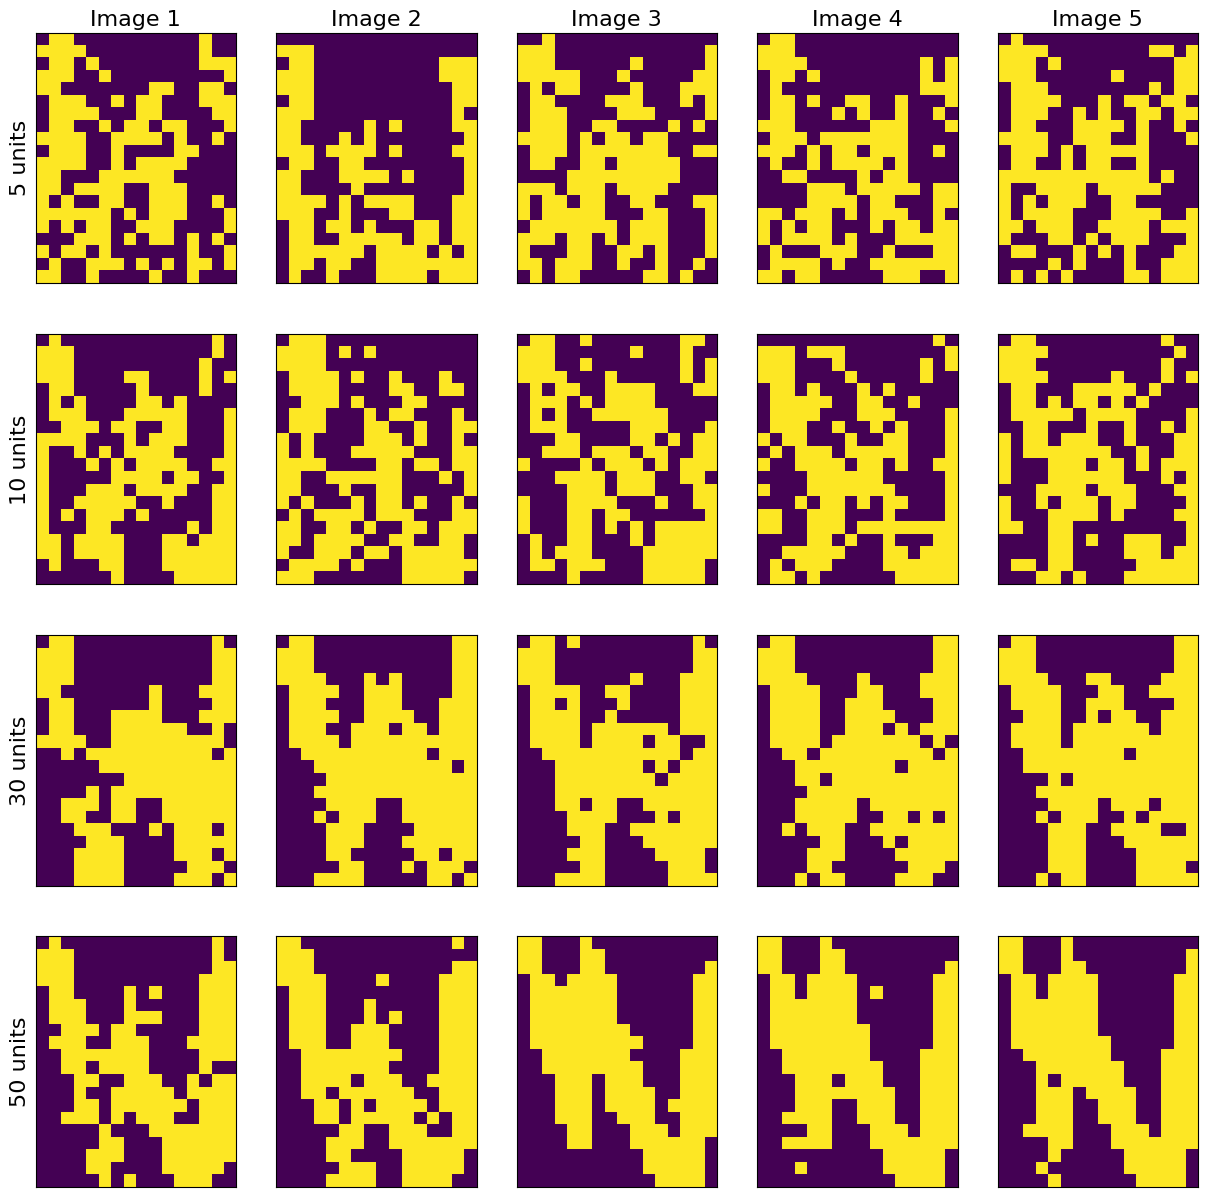

In [32]:
#test RBM on binary ALphaDigits dataset
class_select = ['W']
data = lire_alpha_digit(class_select,'/content/drive/MyDrive/DL2/binaryalphadigs.mat')

plt.figure(figsize=(15, 15))
nb_hidden_list = [5,10,30,50]
#RBM model
for k in range(4):
  print("training model ",k+1)
  nh = nb_hidden_list[k]
  model = RBM(data[0].shape[0],nh)
  errors = model.train_RBM(data,n_epochs_RBM,lr_RBM,batch_size_RBM)
  gen_im = model.generer_image_RBM(n_iter_Gibbs,n_imgs)


  n_imgs = 5
  for i in range(n_imgs):
      ax = plt.subplot(4, n_imgs, k * n_imgs + i + 1)
      plt.imshow(gen_im[i].reshape(20, 16), cmap='viridis')
      if k==0:
        ax.set_title(f'Image {i+1}', fontsize=16, pad=5)
      ax.set_xticks([])
      ax.set_yticks([])
      if i == 0:
        ax.set_ylabel(f'{nh} units',fontsize=16)

#plt.suptitle("RBM Generated Images - Trained on {}".format(class_select), fontsize=16, fontweight='bold', color='navy')
plt.savefig("rbm_hidden_units.png")


training model  1
training model  2
training model  3
training model  4


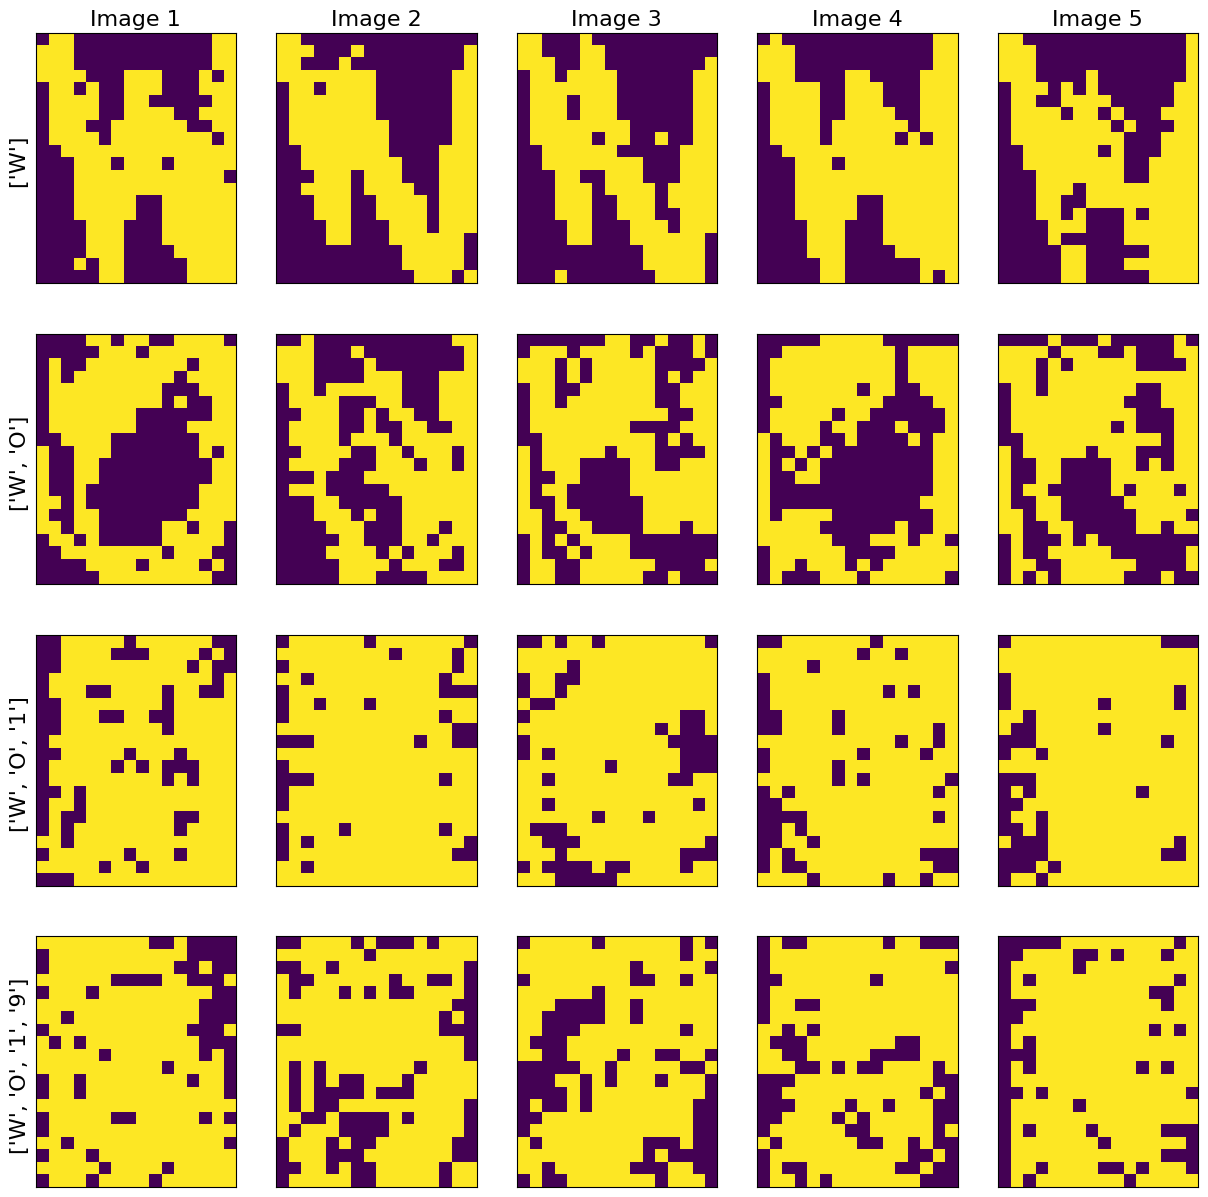

In [36]:
#test RBM on binary ALphaDigits dataset
class_select = ['W','O','1','9']
data_all = lire_alpha_digit(class_select,'/content/drive/MyDrive/DL2/binaryalphadigs.mat')

plt.figure(figsize=(15, 15))
nb_hidden_list = [5,10,30,50]
errors_list =[]
#RBM model
for k in range(4):
  print("training model ",k+1)
  data = data_all[:39*(k+1)]
  model = RBM(data[0].shape[0],nh)
  errors = model.train_RBM(data,n_epochs_RBM,lr_RBM,batch_size_RBM)
  errors_list.append(errors)
  gen_im = model.generer_image_RBM(n_iter_Gibbs,n_imgs)


  n_imgs = 5
  for i in range(n_imgs):
      ax = plt.subplot(4, n_imgs, k * n_imgs + i + 1)
      plt.imshow(gen_im[i].reshape(20, 16), cmap='viridis')
      if k==0:
        ax.set_title(f'Image {i+1}', fontsize=16, pad=5)
      ax.set_xticks([])
      ax.set_yticks([])
      if i == 0:
        ax.set_ylabel(f'{class_select[:k+1]} ',fontsize=16)

#plt.suptitle("RBM Generated Images - Trained on {}".format(class_select), fontsize=16, fontweight='bold', color='navy')
plt.savefig("rbm_char.png")


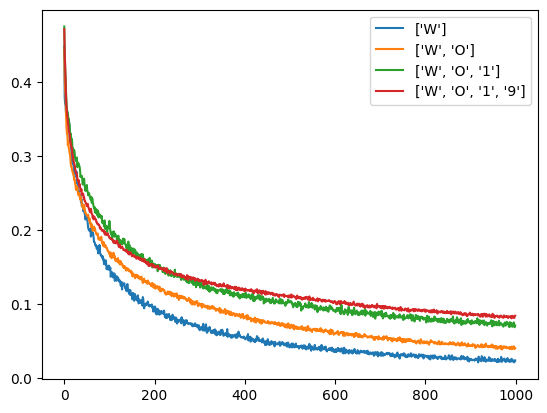

In [38]:
for i in range(len(errors_list)):
  plt.plot([i for i in range(n_epochs_RBM)],errors_list[i], label=f'{class_select[:i+1]}')
plt.legend()
plt.savefig("rbm_char.png")

start train
Entraînement de la couche RBM...
Entraînement de la couche RBM...
start train
Entraînement de la couche RBM...
Entraînement de la couche RBM...
Entraînement de la couche RBM...
Entraînement de la couche RBM...
Entraînement de la couche RBM...
start train
Entraînement de la couche RBM...
Entraînement de la couche RBM...
Entraînement de la couche RBM...
Entraînement de la couche RBM...
Entraînement de la couche RBM...
Entraînement de la couche RBM...
Entraînement de la couche RBM...
start train
Entraînement de la couche RBM...
Entraînement de la couche RBM...
Entraînement de la couche RBM...
Entraînement de la couche RBM...
Entraînement de la couche RBM...
Entraînement de la couche RBM...
Entraînement de la couche RBM...
Entraînement de la couche RBM...
Entraînement de la couche RBM...
Entraînement de la couche RBM...


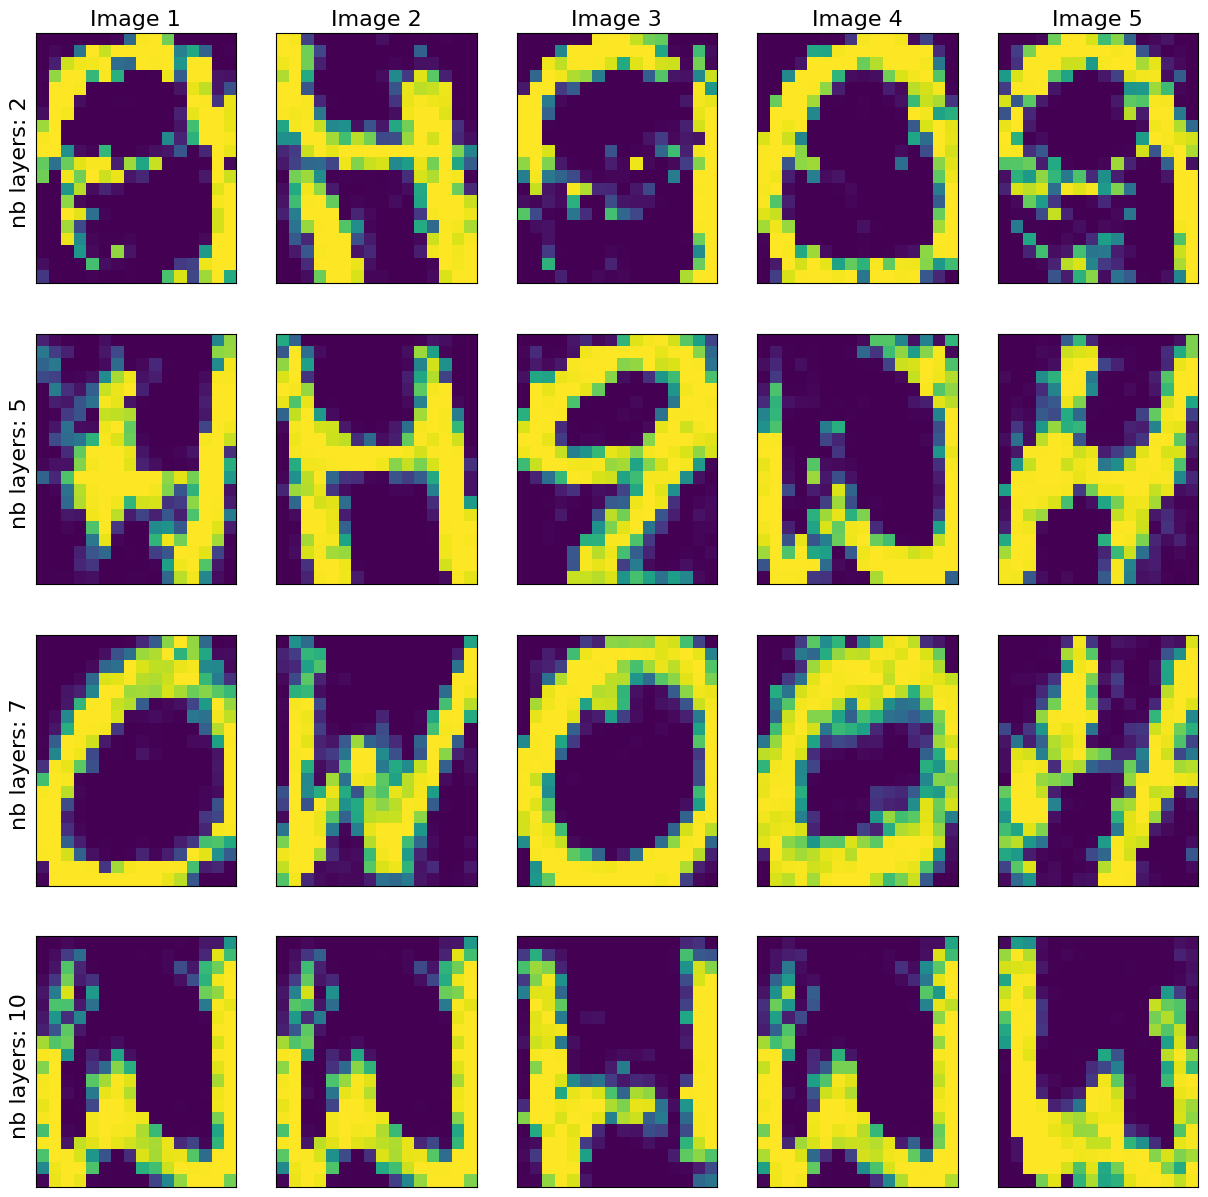

In [19]:
#train DBN on Binary ALphaDigits
class_select = ['W','O','H','9']
data = lire_alpha_digit(class_select,'/content/drive/MyDrive/DL2/binaryalphadigs.mat')

errors_list = []
plt.figure(figsize=(15, 15))
n_layers_list = [2,5,7,10]
nb_hidden = 50
for k in range(len(n_layers_list)):
  print("start train")
  n_layers = n_layers_list[k]
  model = DBN([data.shape[1]]+[nb_hidden]*n_layers)
  model.train_DBN(data,n_epochs_RBM,lr_RBM,batch_size_RBM)

  gen_img = model.generer_image_DBN(n_iter_Gibbs,n_imgs)

  for i in range(n_imgs):
      ax = plt.subplot(4, n_imgs, k * n_imgs + i + 1)
      plt.imshow(gen_img[i].reshape(20, 16), cmap='viridis')
      if k==0:
        ax.set_title(f'Image {i+1}', fontsize=16, pad=5)
      ax.set_xticks([])
      ax.set_yticks([])
      if i == 0:
        ax.set_ylabel(f'nb layers: {n_layers} ',fontsize=16)

#plt.tight_layout()
plt.savefig("dbn_layers.png")

##Etude sur MNIST

In [8]:
#load MNIST dataset

target_classes = ['1','2','5']
train_MNIST, test_MNIST = load_MNIST_data(target_classes,'/content/drive/MyDrive/DL2/mnist_all.mat')
X_train = np.vstack([train_MNIST[c] for c in target_classes])
X_test =  np.vstack([test_MNIST[c] for c in target_classes])

#binarize data
X_train = np.where(X_train >127,1,0)
X_test = np.where(X_test >127,1,0)


labels_train = [np.array([int(c)]*train_MNIST[c].shape[0]) for c in target_classes]
labels_train = list(itertools.chain(*labels_train))
labels_test = [np.array([int(c)]*test_MNIST[c].shape[0]) for c in target_classes]
labels_test = list(itertools.chain(*labels_test))


In [9]:
#labels one hot encoding
encoder = LabelBinarizer()

y_train = encoder.fit_transform(labels_train)
y_test = encoder.transform(labels_test)

Entraînement de la couche RBM...
Entraînement de la couche RBM...


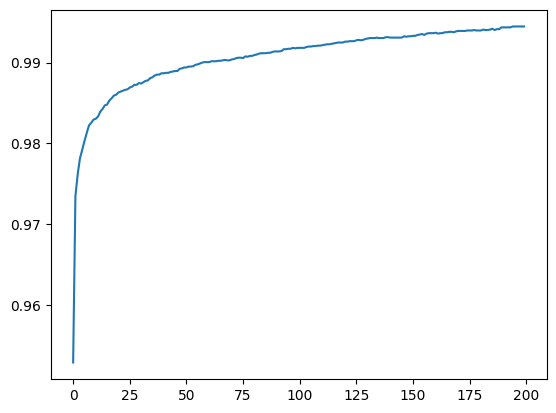

In [75]:
#train DNN on MNIST dataset
nv_hidden = 200
nb_layers = 2
sizes = [X_train.shape[1]] + [nv_hidden]*nb_layers
model = DNN(sizes, y_train.shape[1])
n_epochs_RBM = 100
model.pretrain_DNN(X_train,n_epochs_RBM,lr_RBM,batch_size_RBM)
n_epochs = 200
batch_size = 64
lr = 0.01
errors = model.backprop(X_train,y_train,n_epochs,batch_size,lr)
errors_test = model.test_DNN(X_test,y_test)

plt.plot(range(n_epochs),errors,label='train_error')
plt.plot(range(n_epochs),errors_test,label='test_error')